# Deep Learning Tutorial (Segmentation-Specific)

## -1. Setup

Follow the directions in the README of the [bonelab-pytorch-lightning github repository](https://github.com/Bonelab/bonelab-pytorch-lightning) to set up a good environment for using MONAI and `pytorch-lightning`.

If you do not care about using AIMs and you don't want to use the code I've written for my own projects, feel free to create your own environment using whatever packages you specifically need.


See the note under Imports if you want to run this notebook for yourself.

## 0. Imports

NOTE: I installed a number of additional libraries into my `blptl` environment to make this notebook, these were mostly visualization libraries (e.g. jupyter, seaborn).

If you have installed the `blptl` environment from [here](https://github.com/Bonelab/bonelab-pytorch-lightning) and you are having trouble running this notebook, just activate the env in the terminal and `pip install` whatever library is throwing an error in the cell below. Keep doing that until there's no more errors and it should run.

These libraries are not required for actually training models so they are not in the env by default.

In [1]:
from blpytorchlightning.dataset_components.datasets.PickledDataset import PickledDataset
from blpytorchlightning.dataset_components.transformers.TensorConverter import TensorConverter
from blpytorchlightning.dataset_components.transformers.ComposedTransformers import ComposedTransformers

from blpytorchlightning.tasks.SegmentationTask import SegmentationTask

import math
import random
import torch
import numpy as np
import pandas as pd
import pytorch_lightning as ptl
from matplotlib import pyplot as plt
import seaborn as sns

from monai.networks.nets.unet import UNet

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from tqdm.notebook import trange

## 1. Background

This is a practical tutorial so after this brief section, I'm not going to talk about any math or theory or really say anything about how any of these things really work. If you want to understand more, I recommend reading the textbook located in: /BOYD/04 - Resources/01 - Library/Books/DeepLearning, taking some ML / DL courses (e.g. ENEL645 or the excellent Machine Learning course by Andrew Ng on Coursera), or just googling for articles on specific concepts.

At a high level you can think of any deep learning model as a function $f(\theta | x) = \hat{y}$, where $\theta$ is a vector of model parameters, $x$ is an input tensor, and $\hat{y}$ is a predicted output tensor. In our case here $x$ is an image and $y$ is a segmentation.

> **_NOTE:_** A tensor is a mathematical object of arbitrary dimension.
A 0D tensor is a scalar, a 1D tensor is a vector, a 2D tensor is a matrix, etc.

Given a loss function, $\mathcal{L}(\hat{y},y)$, that computes a scalar loss value for a pair of reference, $y$, and predicted, $\hat{y}$, outputs and a set of $N$ samples, where each sample is an input $x_i$ and a reference $y_i$, we would like to find the $\theta$ that minimizes the loss function averaged over the whole dataset, or equivalently:

$$\theta_\text{optimal} := \mathrm{argmin}_\theta \frac{1}{N} \sum_i^N \mathcal{L}(f(\theta | x_i),y_i)$$

We do this by taking the gradient of the loss function, $\mathcal{L}$, with respect to the parameters, $\theta$, and incrementing the parameters by the gradient, ideally towards the optimal $\theta$ where the loss function is globally minimized:

$$ \Delta \theta = - \epsilon \frac{1}{N} \sum_i^N \frac{\partial  \mathcal{L}(f(\theta | x_i),y_i)}{\partial \theta}  $$

We technically could calculate the gradient over the whole training set at once by accumulating the gradient and updating only once at the end of an epoch, but as it turns out it's more efficient to calculate the gradient for a "minibatch" (usually however many samples the computer can process simultaneously) and update the parameters immediately and just use a smaller learning rate. 

We compute the gradient using "backpropagation" (the chain rule on steroids) but this just the gradient at the particular spot in parameter space we are currently at - the function ("cost surface") will be highly non-linear and so the gradient is only going to point towards a local decrease in the cost function, not necessarily directly towards a minimum. This is why the learning rate, $\epsilon$, is usually a very small number. Too big and you will overshoot a minimum and never converge. Too small and you will converge too slowly and waste lots of computational resources.

There are also a number of other considerations I've left out, such as regularization, adaptive learning rate methods, the specific form of the loss function, etc. I'm not going to specifically cover any of that in this tutorial.

## 2. Pytorch

`pytorch` is the package we're using that gives us all of the tools for deep learning. The other popular alternative would be `tensorflow`.

`pytorch` gives us:
- the `Tensor` data type, that all of our data must be cast to before it can be processed by your deep learning model
- base classes for defining classes for loading data
- a large `nn` module with all of the modular components you use to construct deep learning models

The `Tensor` is very similar to a `numpy.ndarray`, and you can easily convert between `numpy` and `torch`:

In [2]:
arr = np.zeros((1,3,3))
print(arr, "\n", arr.shape, "\n")

tens = torch.from_numpy(arr)
print(tens, "\n", tens.size(), "\n", tens.device, "\n")

arr = tens.numpy()
print(arr, "\n", arr.shape, "\n")

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]] 
 (1, 3, 3) 

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], dtype=torch.float64) 
 torch.Size([1, 3, 3]) 
 cpu 

[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]] 
 (1, 3, 3) 



## 3. Creating Models / MONAI

All kinds of custom models can be created by subclassing `torch.nn.Module` and connecting some components into a pipeline. If you want to see what sort of components are available you have to check the `torch.nn` [documentation](https://pytorch.org/docs/stable/nn.html).

In [3]:
class CustomModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = torch.nn.Conv2d(1, 3, kernel_size=3)
    
    def forward(self, x):
        return self.layer(x)

custom_model = CustomModel()

x = torch.zeros((1, 1, 128, 128))
y_hat = custom_model(x)

torch.onnx.export(custom_model, x, "custom.onnx", input_names=["image"], output_names=["masks"])

In the last line, I saved the model in ONNX format. This is sort of like a universal format for deep learning models that allows you to translate between `pytorch` and `tensorflow` and other libraries, very useful for deployment of models. Saving the model like this also allows us to load it up with [Netron](https://github.com/lutzroeder/netron) to visualize and inspect it...

However, rather than creating everything manually, it's more efficient to just import existing things from existing libraries. For example, MONAI has a ton of highly configurable models that can do segmentation, of course including a "basic" UNet.

To find a list of the available models in MONAI, check the [documentation](https://docs.monai.io/en/stable/networks.html).

In [4]:
unet_spec = {
    "spatial_dims": 2,
    "in_channels": 1,
    "out_channels": 3,
    "channels": [8, 16, 32],
    "strides": [2,2]
}

unet = UNet(**unet_spec)

x = torch.zeros((1, 1, 128, 128))
y_hat = unet(x)

torch.onnx.export(unet, x, "unet.onnx", input_names=["image"], output_names=["masks"])

/Users/nathanneeteson/opt/anaconda3/envs/blptl/lib/python3.7/site-packages/torch/onnx/symbolic_helper.py:1159: UserWarning: ONNX export mode is set to inference mode, but operator instance_norm is set to training  mode. The operators will be exported in training , as specified by the functional operator.
  + ", as specified by the functional operator."


Again, we can visualize with Netron to see what has actually been created.

> **_NOTE:_** MONAI has all kinds of good stuff, including datasets, data augmentation transforms, models, etc. I highly recommend checking if something you want has been implemented in MONAI already before implementing it yourself. If you don't plan on using AIMs and are just using NIFTIs, you might prefer to use the datasets and transforms from MONAI than to use the things I have implemented.

There are also thousands of other repositories and packages out there with prebuilt deep learning models, so before you go to implement something yourself, look on github, google, papers with code, hugging face, etc.  to see if someone has done it for you and you can just download and import it.

## 4. Data Preparation and Loading

Data preparation is very important. You need to do things like pixel value normalization / rescaling, padding/cropping, conversion to `Tensor` type, and perhaps also augmentation related transformations. The specific set of transformations you want to use depends on your input data, and the amount of data you have. You always need to transform your data to `Tensors` at some point in the pipeline. With images, you will nearly always need to either crop/pad to a certain shape, or at least so that the shape of your image is a multiple of a certain number (this is model-dependent). You will always need to somehow rescale the pixel values to be in the approximate range (-1,1) - this has to do with ensuring "activation functions" within the model behave properly. 

You may want to use various forms of data augmentation to artificially increase the size of your dataset, and this can include flips, rotations, scale/skew/deformation transforms, adding noise, spatial filtering, and more. However, it is very important that you ensure any data augmentation you use (1) has been properly set up so that the transformations are not destroying the sample's usefulness, and (2) that the transformations make physiological sense. The purpose of data augmentation is to make your dataset more accurately reflect the distribution of data you expect future data to be drawn from. So any transformation applied to augment your data should represent a physiologically / physically permissible variation.

File I/O combined with these data transformations is very expensive and slow, often forming a bottleneck for training models quickly if you do everything at once in a single script/job. 

For this reason I recommend doing data preparation ahead of time, saving the prepped data in a file format for optimal I/O speed. This is critical if you are using ARC: you want to do data preparation on CPU partitions/nodes, and then do your model training using prepped data on GPU partitions/nodes. This will use ARC resources most efficiently, and more importantly your training workflow will be much faster, allowing you to train more models and iterate faster.

We can tab out over from this notebook to a code editor to look at a very simple script I wrote to prep some HR-pQCT data for this tutorial (simple because it takes advantage of a number of classes I created and put in `blpytorchlightning`)...

> **_NOTE:_**  If you're looking at this later, the script is `./data_prep/data_prep.py`

Create a `PickledDataset` to load the data that I prepared ahead of time:

In [5]:
dataset = PickledDataset("data", transformer=TensorConverter(ohe=False))
print(f"There are {len(dataset)} images in the dataset.")

There are 100 images in the dataset.


The dataset is an iterable that will return a "sample" corresponding a given index. A sample can be anything in principle, it depends on how the dataset class was written. What's important is that everything in your pipeline is consistent with each other: datasets, transforms, and your training code (whether it's a manual loop or a lightning module) need to all expect a sample to have the same form. Once you have achieved that then you can create modular objects you can (somewhat) arbitrarily connect into data loading and model training pipelines.

In this case a `PickledDataset` was created explicitly for image segmentation, so it returns a `tuple` where the first element is the image and the second element is the mask:

In [6]:
sample = dataset[0]
print(sample[0].shape, sample[0].min(), sample[0].max())
print(sample[1].shape, sample[1].min(), sample[1].max())

torch.Size([1, 128, 128]) tensor(-1.) tensor(1.)
torch.Size([128, 128]) tensor(0) tensor(2)


The image has already been rescaled so the pixel values are between -1 and 1 before the data was pickled. We have also sampled out 128x128 patches that center on the cortex so that our model can be trained relatively quickly. In normal circumstances you don't want artificially small data, you want to select a sample size that uses all of a GPU's available VRAM while optimizing the trade-off between sample size and batch size. 

What's optimal? You just have to try stuff and see. However a good rule of thumb would be you don't want to get down to a batch size less than 4, and at the same time you want to make the spatial extent of your samples large enough to at least contain the full spatial context the model requires. This puts a practical constraint on how complex your segmentation model can be and/or the size of image data you can work with, which is dependent on the hardware you have access to.

The mask contains integer values; 0=cort, 1=trab, 2=background.

Now that we have a dataset initialized, we can plot some sample data and also pass it through the untrained model to see predictions just for fun:

In [7]:
# define a dice coefficient function to add a useful metric to the plot
def dice(x, y):
    return 2*np.sum(x&y) / (np.sum(x) + np.sum(y))

# define a function so we can do this again later on
def create_sample_plots(dataset, model, num_plots, mask_opacity):
    fig, axs = plt.subplots(2, num_plots, figsize=(3*num_plots,6))

    for i, (ax_upp, ax_low) in enumerate(zip(axs[0],axs[1])):

        img, mask = dataset[random.randint(0, len(dataset)-1)]
        mask_pred = model(img.unsqueeze(0)).argmax(dim=1)

        img = img.numpy()
        cort = (mask==0).numpy()
        trab = (mask==1).numpy()

        cort_pred = (mask_pred[0,...]==0).detach().numpy()
        trab_pred = (mask_pred[0,...]==1).detach().numpy()

        ax_upp.imshow(img[0,...], cmap="gist_gray", vmin=-1, vmax=1)
        ax_upp.imshow(cort, cmap="Greens", alpha=mask_opacity*cort.astype(float))
        ax_upp.imshow(trab, cmap="Blues", alpha=mask_opacity*trab.astype(float))

        ax_low.imshow(img[0,...], cmap="gist_gray", vmin=-1, vmax=1)
        ax_low.imshow(cort_pred, cmap="Greens", alpha=mask_opacity*cort_pred.astype(float))
        ax_low.imshow(trab_pred, cmap="Blues", alpha=mask_opacity*trab_pred.astype(float))

        ax_upp.axis("off")
        ax_low.axis("off")
        
        cort_dice, trab_dice = dice(cort, cort_pred), dice(trab, trab_pred)
        ax_upp.set_title(f"cort DSC: {cort_dice:0.2f}\ntrab DSC: {trab_dice:0.2f}")

    plt.tight_layout()
    
    plt.show()

    print("TOP ROW: Reference masks. BOTTOM ROW: Predictions from model.")

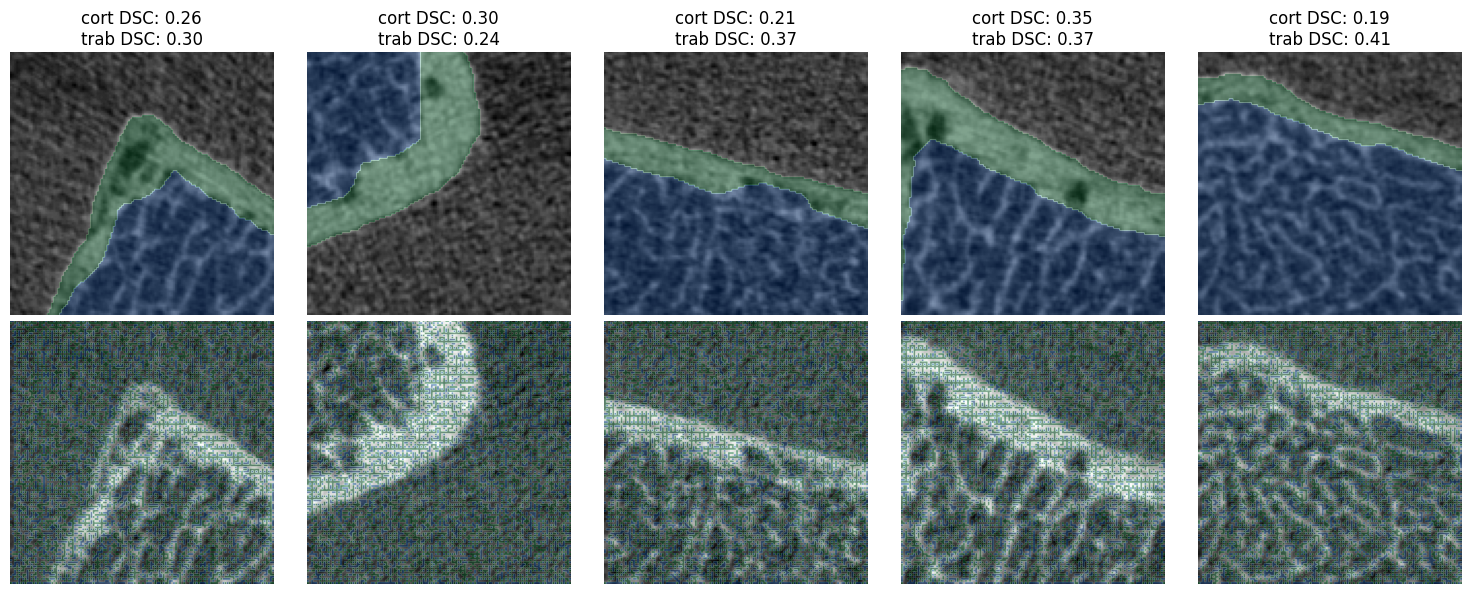

TOP ROW: Reference masks. BOTTOM ROW: Predictions from model.


In [8]:
num_plots = 5
mask_opacity = 0.5

create_sample_plots(dataset, unet, num_plots, mask_opacity)

The UNet was initialized with random numbers for the parameters, so before we have trained it, the output predictions are random and look like noise.

Sometimes you will have a dataset and a transformation that are incompatible. For example, my dataset classes return samples that are tuples, while MONAI dictionary transformations expect samples to be dictionaries where you specify which elements of the dictionary to transform. This is a nice way to do it because then you can specify that the transform should be applied to the image but not to the mask, for example. But, you can't use it with the dataset I have written:



In [9]:
from monai.transforms import RandGaussianNoised

dataset_noise = PickledDataset(
    "data", 
    transformer=ComposedTransformers([
        RandGaussianNoised(keys=["image"], prob=0.5, mean=0, std=1),
        TensorConverter(ohe=False)
    ]) 
)

try:
    sample = dataset_noise[0]
    print("It worked!")
except ValueError as e:
    print("ValueError:", e)

ValueError: dictionary update sequence element #0 has length 1; 2 is required


To make them compatible you can very easily define some adapter functions. For MONAI's dictionary transforms specifically, we just need a function that converts the tuple sample to a dictionary sample to use the MONAI transform, then we need to transform back to tuple to be compatible with the rest of my pipeline:

In [10]:
def tuple_to_dict(t):
    return {"image": t[0], "masks": t[1]}

def dict_to_tuple(d):
    return d["image"], d["masks"]

dataset_noise = PickledDataset(
    "data", 
    transformer=ComposedTransformers([
        tuple_to_dict,
        RandGaussianNoised(keys=["image"], prob=0.5, mean=0, std=1),
        dict_to_tuple,
        TensorConverter(ohe=False)
    ]) 
)

try:
    sample = dataset_noise[0]
    print("It worked!")
except ValueError as e:
    print("ValueError:", e)

It worked!


You can use `ComposedTransformers` to create a new transformer object that will execute arbitrarily many transformations in the order they're given in the list. It's your responsibility to ensure that the output of a transform is compatible with the expected input of the next transform, and that the final transform will output something compatible with your dataloader and with your model.

You can use the adapter functions I have provided above for segmentation problems, for other sorts of models you'll want to define adapter functions that make sense for your data.

Let's create more sample plots and verify that adding the noise transform to the pipeline worked...

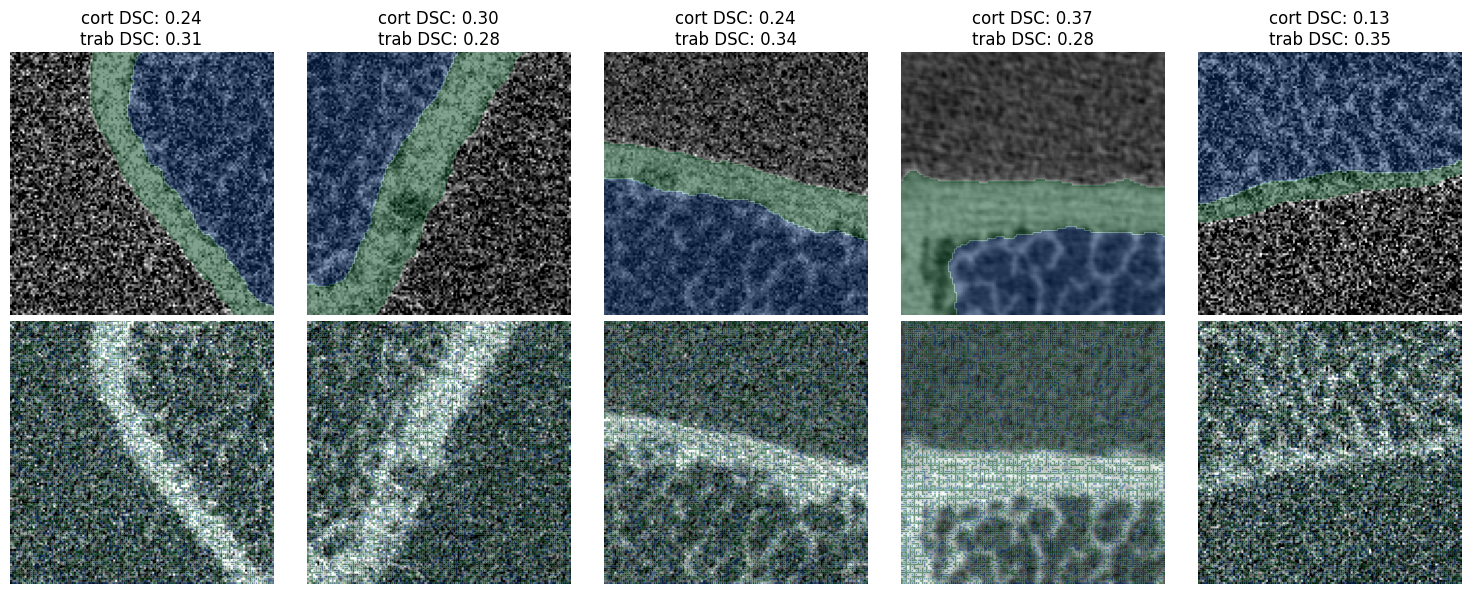

TOP ROW: Reference masks. BOTTOM ROW: Predictions from model.


In [11]:
num_plots = 5
mask_opacity = 0.5

create_sample_plots(dataset_noise, unet, num_plots, mask_opacity)

To streamline the process of loading data when training a deep learning model, we use an object that in pytorch is called a `DataLoader`. A `DataLoader` will take care of things like random shuffling, using multiple CPUs to load data in parallel, batching, etc. Here we want to split our data into 3 sub-sets: train/val/test. We will use `numpy` to randomly assign samples to each group and then create a `DataLoader` for each, using the `Subset` object to assign only subsets of the dataset to each dataloader.

In [12]:
batch_size = 16

train_prop = 0.6
val_prop = 0.2

idxs = np.arange(0, len(dataset))
np.random.shuffle(idxs)

train_idxs = idxs[:math.floor(train_prop*len(dataset))]
val_idxs = idxs[math.floor(train_prop*len(dataset)):math.floor((val_prop+train_prop)*len(dataset))]
test_idxs = idxs[math.floor((val_prop+train_prop)*len(dataset)):]

print("train idxs: ", train_idxs, "\n")
print("val idxs: ", val_idxs, "\n")
print("test idxs: ", test_idxs, "\n")

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(dataset, train_idxs), 
    batch_size=batch_size, shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(dataset, val_idxs), 
    batch_size=batch_size, shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    torch.utils.data.Subset(dataset, test_idxs), 
    batch_size=batch_size, shuffle=False
)

print(f"Lengths of dataloaders: {len(train_loader)}, {len(val_loader)}, {len(test_loader)}")

train idxs:  [88 25 81 78 63 89 85 74 12 14 60 58 82 21 31 91 48 26 84 80 22 13 99 18
 70 33 27 41 98  4 24 67 37 17 20 86 43 53 49  9  3 79 15 52 19 39 71 55
 57 95 40 51 38 10 73 44 92 64 69 66] 

val idxs:  [65 30 11  2 28 35 32 47 46  0 34 50 62 94  8 93 23 72 87 59] 

test idxs:  [16  6  7 54 96 68 56 36 83 61  1 75 42  5 90 76 45 29 97 77] 

Lengths of dataloaders: 4, 2, 2


Note that the length of the dataloader is not the number of samples, but the number of minibatches. The number of minibatches will be approximately the number of samples divided by the batch size.

In [13]:
batch = next(iter(train_loader))
print(batch[0].size(), batch[1].size())

torch.Size([16, 1, 128, 128]) torch.Size([16, 128, 128])


## 6. Model Optimization

Now we have a model that takes an image and predicts a segmentation, and a dataloader that will load pairs of images and reference masks, convert them to pytorch `Tensor`s, and group them into batches for parallel processing. 

The next thing we need is a process for comparing a prediction and a reference mask, and then updating the model based on the result of the comparison. These are accomplished using a loss function and an optimizer, respectively.

In [14]:
learning_rate = 1e-2

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    unet.parameters(),
    lr=learning_rate
)

We can then increment the parameters in the model towards an optimal solution by:

1. Zero out any gradients that might be left over from prior operations.

2. Get a batch from the dataloader, make a prediction using the input.

3. Compute the loss using the prediction and reference output, then compute the gradient of the loss with respect to the model parameters.

4. Increment the parameters of the model by the product of the learning rate and the gradient.

In [15]:
# step 1
optimizer.zero_grad()

# step 2
x, y = next(iter(train_loader))
y_hat = unet(x)

# step 3
loss = loss_function(y_hat,y)
loss.backward()

# step 4
optimizer.step()

## 7. The Training Loop

To actually train a model on a dataset, you need to do the optimization process shown above many many times. Typically there will be two nested loops: In the inner loop, we iterate over all of the batches in the training and validation dataloaders, using the training data to update the model incrementally and the validation data to check for overfitting. In the outer loop, we simply loop over "epochs" and repeat the training process until the training has converged, or until we stop seeing improvement on the validation dataset.

In [16]:
num_epochs = 100

losses = {
    "training": [],
    "validation": []
}

for epoch in trange(num_epochs):
    
    # TRAINING
    
    losses["training"].append(0)
    
    unet.train()
    
    for batch in train_loader:
        
        # step 1
        optimizer.zero_grad()

        # step 2
        x, y = batch
        y_hat = unet(x)

        # step 3
        loss = loss_function(y_hat,y)
        loss.backward()
        losses["training"][-1] += loss.item()

        # step 4
        optimizer.step()
    
    losses["training"][-1] = losses["training"][-1] / len(train_loader)
    
    # VALIDATION
    
    losses["validation"].append(0)
    
    unet.eval()
    
    for batch in val_loader:
        
        x, y = batch
        with torch.no_grad():
            y_hat = unet(x)
        
        loss = loss_function(y_hat,y)
        
        losses["validation"][-1] += loss.item()
    
    losses["validation"][-1] = losses["validation"][-1] / len(val_loader)

  0%|          | 0/100 [00:00<?, ?it/s]

I added some extra lines to keep track of the average loss in each epoch for both the training and validation data. Of course this is an extremely simple training loop. I haven't dealt with moving data from the CPU to the GPU (cannot do this on a macbook anyways), I never saved the hyperparameters or the model parameters to file, I'm not computing any metrics other than the loss, etc. I'm intentionally not doing any of that to keep it simple but also because it's not necessary to implement any of this manually anymore - it's actually a huge waste of time, as we will see in the next section.

However, just to demonstrate how training went, we can plot the training and validation losses against the epoch number:

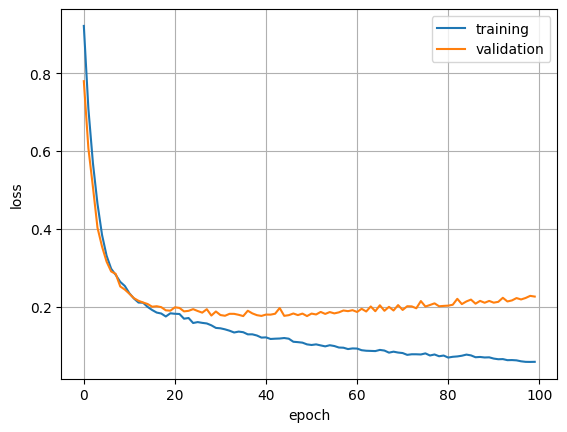

In [17]:
fig = plt.figure()

for k,v in losses.items():
    plt.plot(v, label=k)
    
plt.legend()

plt.xlabel("epoch")
plt.ylabel("loss")

plt.grid()

plt.show()

This is pretty nice. We have good exponential convergence of the training loss, and we can see that at some point the validation loss inflects and starts to increase. That's the point where we start to overfit our training data, and afterwards the gap between the training and validation loss curves is called the "generalization gap."

We can also visualy inspect how the model is doing using the function we created eariler:

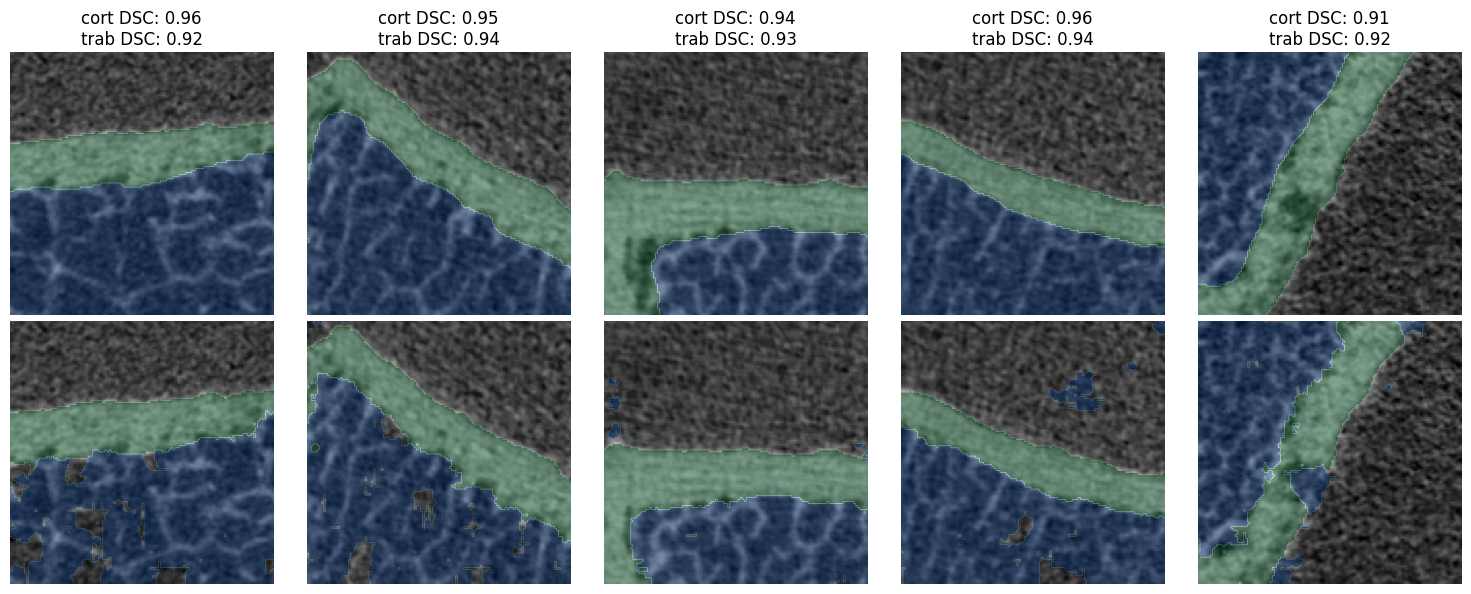

TOP ROW: Reference masks. BOTTOM ROW: Predictions from model.


In [18]:
num_plots = 5
mask_opacity = 0.5

create_sample_plots(
    torch.utils.data.Subset(dataset, val_idxs), 
    unet, num_plots, mask_opacity
)

Obviously not perfect, but pretty nice considering there are only 60 slices in the training dataset and we trained the model for ~30 seconds on a CPU.

Pay attention to how the masks look OK but there are gigantic errors all over the place when you look closely, and that nearly all of the DSC values are >0.9! These overlap metrics can be very misleading when presented without any visual examples or any other more meaningful performance metrics. What is a "good" Dice score is very context-dependent. For HR-pQCT segmentation, DSC < ~0.95 is pretty much terrible, and even then you still have to be careful. For other tasks, such as tumour or BML segmentation, you might consider DSC > 0.8 to be excellent.

## 8. Pytorch-Lightning

`pytorch-lightning` is basically the `pytorch` equivalent of `tensorflow`'s `keras`. By that I mean it is a higher level library that sits on top of `pytorch` and eliminates the need to write a lot of "boiler plate" code that you would otherwise have to include in every project.

All you need to do is define how the loss should be calculated from a batch for each type of step (training, validation, testing, predicting) and it will automate the entire training process, usually doing things more correctly and more efficiently than you or I would have if we did it all manually.

It also takes care of a lot of complexity that was not illustrated in the very simple example training loop above, including: moving tensors from CPU to GPU, saving your model parameters and hyperparameters to file, parallelization across multiple devices, logging results to file (in an organized way), stopping the training process before overfitting, and many more things.

Defining a Lightning Module is not that difficult, but because of the required structure the code ends up looking a bit daunting / lengthy. Because of that I will not define a lightning module here, instead I import one I created for image segmentation a while ago.

In [19]:
# create a new unet to start fresh
unet = UNet(**unet_spec)

In [20]:
# create an instance of a SegmentationTask and pass it the unet and the loss function
task = SegmentationTask(unet, loss_function, learning_rate)

In [21]:
# create loggers
logger_kwargs = {
    "save_dir": "logs",
    "name": "tutorial"
}
csv_logger = CSVLogger(**logger_kwargs)

# create callbacks
early_stopping = EarlyStopping(
    monitor='val_dsc_0',
    mode='max',
    patience=20
)

In [22]:
# create a Trainer and fit the model

# this line would log your hyperparameters to a yaml file if you 
# wanted to be able to keep track of your experiments easily
#csv_logger.log_hyperparams(args)
# "args" is a variable that in my case I would produce using the argparse package
# if this was a configurable script I was using to run training jobs on ARC

trainer = Trainer(
    accelerator="cpu",
    devices=1,
    strategy=None,
    max_epochs=num_epochs,
    log_every_n_steps=1,
    logger=csv_logger,
    callbacks=[early_stopping]
)
trainer.fit(task, train_loader, val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | UNet             | 9.8 K 
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
9.8 K     Trainable params
0         Non-trainable params
9.8 K     Total params
0.039     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/nathanneeteson/opt/anaconda3/envs/blptl/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/Users/nathanneeteson/opt/anaconda3/envs/blptl/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

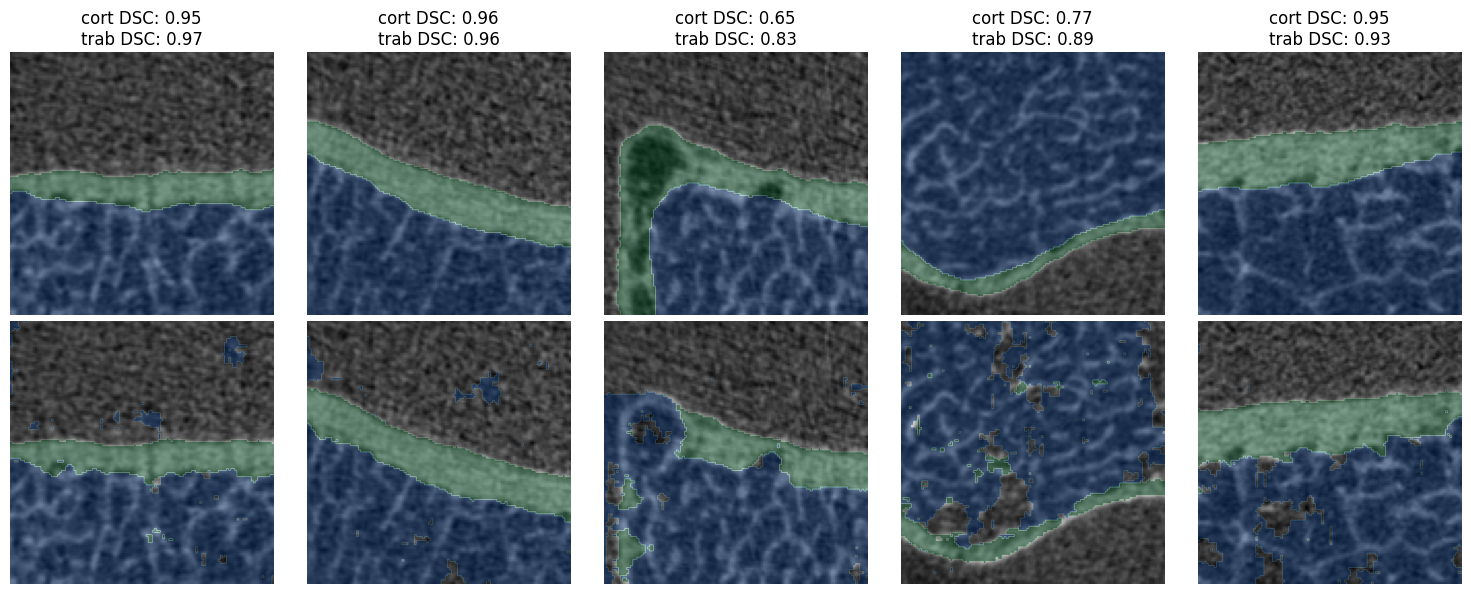

TOP ROW: Reference masks. BOTTOM ROW: Predictions from model.


In [23]:
num_plots = 5
mask_opacity = 0.5

create_sample_plots(
    torch.utils.data.Subset(dataset, val_idxs), 
    unet, num_plots, mask_opacity
)

## 9. Performance Evaluation

Pytorch Lightning takes care of tracking metrics and logging them, they all go into a CSV file called `metrics.csv` within the directory corresponding to the experiment/version. We can load this CSV file using `pandas` and then use `pyplot` and `seaborn` to plot our metrics just like when we did the manual training loop. Except now we also get the Dice coefficient for each mask and in each data subset, because the `SegmentationTask` we imported does this for us. In general you can add whatever metrics you want into your lightning modules and they will be tracked and logged, and can be used as the basis metric for deciding when the model has converged. You can either implement these metrics yourself or see if someone has already made it available in a package such as `torchmetrics`.

NOTE: I like using `seaborn` when I have to create visualizations from `pandas` dataframes, just a bit nicer to work with than vanilla `pyplot` in this case.

In [24]:
df = pd.read_csv("logs/tutorial/version_1/metrics.csv")
df

train_loss_step  train_dsc_0_step  train_dsc_1_step  train_dsc_2_step  \
0           1.217131          0.144448          0.314211          0.152578   
1           1.078111          0.305213          0.346617          0.300431   
2           1.000394          0.479968          0.378173          0.511398   
3           0.948417          0.598054          0.452625          0.588573   
4                NaN               NaN               NaN               NaN   
..               ...               ...               ...               ...   
747         0.189309          0.910010          0.914109          0.954244   
748              NaN               NaN               NaN               NaN   
749              NaN               NaN               NaN               NaN   
750              NaN               NaN               NaN               NaN   
751              NaN               NaN               NaN               NaN   

     epoch  step  val_loss_step  val_dsc_0_step  val_dsc_1_step  \
0      0.0     0            NaN             NaN             NaN   
1      0.0     1            NaN             NaN             NaN   
2      0.0     2            NaN             NaN             NaN   
3      0.0     3            NaN             NaN             NaN   
4      NaN     0       0.861560        0.745561        0.516030   
..     ...   ...            ...             ...             ...   
747    0.0     3            NaN             NaN             NaN   
748    NaN     0       0.309170        0.827887        0.885376   
749    NaN     1       0.386549        0.793771        0.875203   
750    0.0     3            NaN             NaN             NaN   
751    0.0     3            NaN             NaN             NaN   

     val_dsc_2_step  val_loss_epoch  val_dsc_0_epoch  val_dsc_1_epoch  \
0               NaN             NaN              NaN              NaN   
1               NaN             NaN              NaN              NaN   
2               NaN             NaN              NaN              NaN   
3               NaN             NaN              NaN              NaN   
4          0.710603             NaN              NaN              NaN   
..              ...             ...              ...              ...   
747             NaN             NaN              NaN              NaN   
748        0.934183             NaN              NaN              NaN   
749        0.943009             NaN              NaN              NaN   
750             NaN        0.324646         0.821064         0.883341   
751             NaN             NaN              NaN              NaN   

     val_dsc_2_epoch  train_loss_epoch  train_dsc_0_epoch  train_dsc_1_epoch  \
0                NaN               NaN                NaN                NaN   
1                NaN               NaN                NaN                NaN   
2                NaN               NaN                NaN                NaN   
3                NaN               NaN                NaN                NaN   
4                NaN               NaN                NaN                NaN   
..               ...               ...                ...                ...   
747              NaN               NaN                NaN                NaN   
748              NaN               NaN                NaN                NaN   
749              NaN               NaN                NaN                NaN   
750         0.935948               NaN                NaN                NaN   
751              NaN          0.182664           0.901937            0.92867   

     train_dsc_2_epoch  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
..                 ...  
747                NaN  
748                NaN  
749                NaN  
750                NaN  
751           0.961219  

[752 rows x 18 columns]

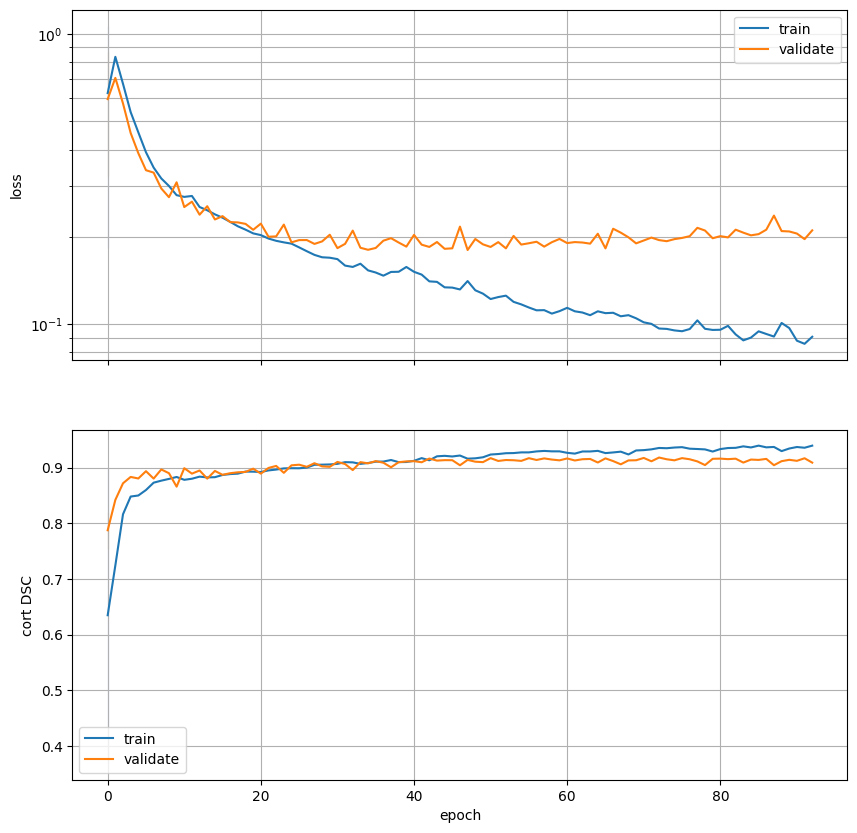

In [25]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10,10))

sns.lineplot(ax=axs[0], data=df, x="epoch", y="train_loss_epoch", label="train")
sns.lineplot(ax=axs[0], data=df, x="epoch", y="val_loss_epoch", label="validate")

sns.lineplot(ax=axs[1], data=df, x="epoch", y="train_dsc_0_epoch", label="train")
sns.lineplot(ax=axs[1], data=df, x="epoch", y="val_dsc_0_epoch", label="validate")

axs[0].set_ylabel("loss")
axs[1].set_ylabel("cort DSC")

axs[0].set_yscale("log")

for ax in axs:
    ax.grid(which="both")

plt.show()

Comparing performance between models for the purposes of hyperparameter optimization or model selection is outside of the scope of this tutorial, but it can be done fairly easily by parsing through the `logs` directory and loading metrics and hyperparameters, then using `pandas` to construct one large dataframe with all metrics for all versions. Then you can analyze, or you can save it as a new CSV to be analyzed later.

Examples of this can be found [here](https://github.com/Bonelab/hrpqct-knee-segmentation/blob/main/python/analysis/parse_logs.py) and [here](https://github.com/Bonelab/hrpqct-knee-segmentation/blob/main/notebooks/analyze_rad_tib_cv.ipynb), though not well-documented. My workflow is typically to parse all of the logs on ARC and construct a big CSV with the final metrics from each model (for each model type/architecture), then take all of these CSVs to my macbook and analyze them together in a notebook.

## 10. Predicting on New Data

In this section I'll quickly cover how to load up a model you trained earlier using Pytorch Lightning, and then use it to to predictions on new data (the test data subset).

In [26]:
# create a new unet
unet = UNet(**unet_spec)

# create an instance of a SegmentationTask and pass it the unet and the loss function
# we have to create the task precisely how we created it when we trained the model
# this is why you really should log your hyperparameters in the log directories,
# then you can read then in and make sure you create the task exactly the same
task = SegmentationTask(unet, loss_function, learning_rate)

Verify that the model in the task is not trained:

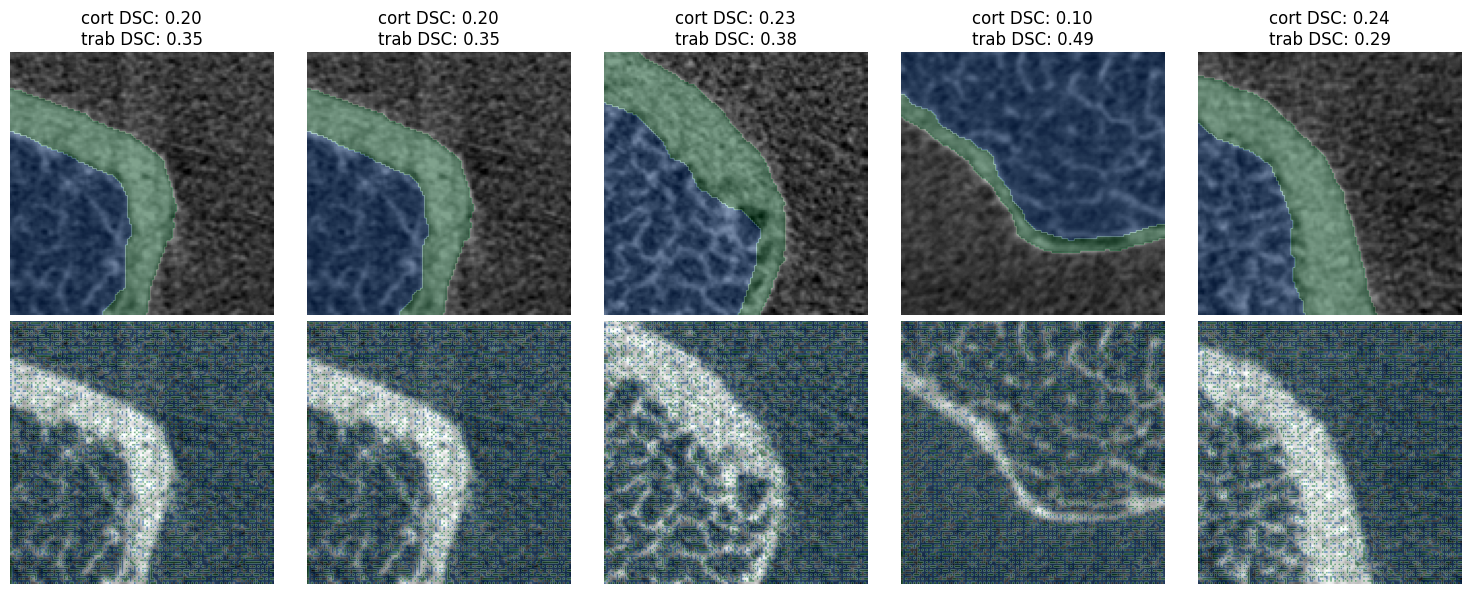

TOP ROW: Reference masks. BOTTOM ROW: Predictions from model.


In [27]:
num_plots = 5
mask_opacity = 0.5

create_sample_plots(
    torch.utils.data.Subset(dataset, test_idxs), 
    task, num_plots, mask_opacity
)

Now load the model from the checkpoint:

In [28]:
task = task.load_from_checkpoint(
    "logs/tutorial/version_1/checkpoints/epoch=92-step=372.ckpt",
    model=unet, loss_function=loss_function
)

And verify we have loaded a trained model:

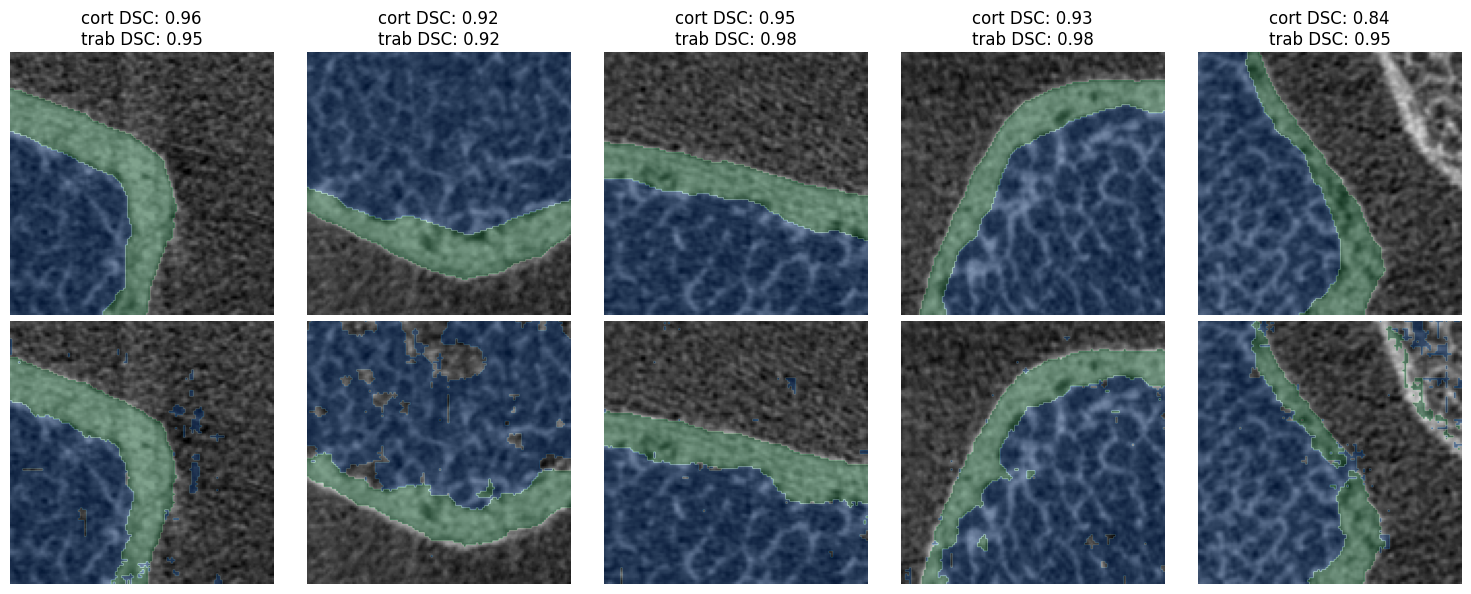

TOP ROW: Reference masks. BOTTOM ROW: Predictions from model.


In [29]:
num_plots = 5
mask_opacity = 0.5

create_sample_plots(
    torch.utils.data.Subset(dataset, test_idxs), 
    task, num_plots, mask_opacity
)

What if you want to do predictions / inference on a whole image and not just some preprocessed prepped data? You just have to write a script that loads your trained model, loads up an image to process, processes the image *exactly* the same way you preprocessed the data for training, then do your inference. If you are using a "fully convolutional" model your input tensors can actually be any size, subject to model-specific constraints (e.g. in the UNet family of models, the dimensions of inputs must be a multiple of $2^m$ where $m$ is the number of downsampling operations in the decoder). If you are using a transformer-based model, your model will only be able to take a specific input image size.

In the cell below I will load an AIM and do a prediction on the entire image. Note that I am using a padding transform to make sure the x-y dimensions the image are compatible with my UNet (divisible by 8) and a rescaling transform to convert from the density range (-400, 1400) mg HA/ccm to the normalized range (-1,1). I'm doing this because that's how the training data was preprocessed, so that's what the model expects.

In [36]:
from vtkbone import vtkboneAIMReader
from bonelab.util.aim_calibration_header import get_aim_density_equation
from bonelab.util.vtk_util import vtkImageData_to_numpy

from monai.transforms import DivisiblePadd, ScaleIntensityRanged

test_img_fn = "/Users/nathanneeteson/Documents/Data/Images/UNet/NORMXTII_0051_TL.AIM"

reader = vtkboneAIMReader()
reader.DataOnCellsOff()

scaler = ScaleIntensityRanged(
    keys=["image"], 
    a_min=-400, a_max=1400, b_min=-1, b_max=1,
    clip=True
)
padder = DivisiblePadd(keys=["image"], k=[8,8,0])

reader.SetFileName(test_img_fn)
reader.Update()

img = vtkImageData_to_numpy(reader.GetOutput())

m, b = get_aim_density_equation(reader.GetProcessingLog())
img = m*img + b
img = np.expand_dims(img,0)

img = scaler(padder({"image": img}))["image"]

mask = np.zeros_like(img)

for i in trange(img.shape[3]):
    x = (img[...,i]).unsqueeze(0)
    with torch.no_grad():
        pred = task(x)
    mask[...,i] = torch.argmax(pred,dim=1).detach().numpy()

  0%|          | 0/168 [00:00<?, ?it/s]

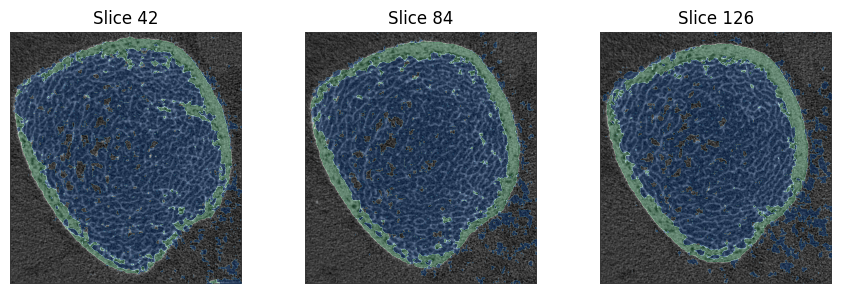

In [31]:
cort = mask==0
trab = mask==1


fig, axs = plt.subplots(1,3, figsize=(9,3))


for i, ax in zip([168//4, 2*168//4, 3*168//4], axs):
    
    ax.imshow(img[0,...,i], cmap="gist_gray", vmin=-1, vmax=1)
    ax.imshow(cort[0,...,i], cmap="Greens", alpha=mask_opacity*cort[0,...,i].astype(float))
    ax.imshow(trab[0,...,i], cmap="Blues", alpha=mask_opacity*trab[0,...,i].astype(float))
    
    ax.set_title(f"Slice {i}")
    
    ax.axis("off")
    
plt.tight_layout()

plt.show()

This worked because our model is a UNet. As said previously, if you have a transformer-based model, it will only be able to process samples of a specific size. In that case you will have to break your image into chunks and process them sequentially, stitching them back into a full mask as you go.

## 11. Cross-Validation

Most of the time, you do not have the luxury of separating out a nice test data subset to leave untouched until you want to perform a final model performance evaluation. Usually because you do not have enough data, or because none of your data qualifies as "untouched." In this case, to estimate the performance of your model on unseen data, you perform "k-fold cross-validation."

In k-fold cross-validation (CV) you split your dataset into k folds. Then you train a model and evaluate its performance on a validation k times. In each iteration, you select 1 of the k folds as the validation subset, and the remaining k-1 form the training subset. After, you can average the metrics across all k folds to get a conservative estimate for performance on unseen data.

Performing k-fold CV is quite easy with Pytorch Lightning. We can use the same strategy as we did previously to seperate our dataset into training, validation, and test subsets. Only now we separate it into k equal partitions.

> **_NOTE:_** There are cases where you might want to perform "stratified splitting" rather than just randomly splitting all of your data into groups. I'm not going to cover this but you can look into it if you think it would be relevant for you (e.g. you have some people with "good" bones and some people with "bad" bones and you don't want all of the "bad" bones to randomly end up in one group together). The `scikit-learn` package has functions for automatically performing these kinds of dataset splitting operations.

In [32]:
num_folds = 3

# create the fold index lists
idxs = np.arange(0, len(dataset))
np.random.shuffle(idxs)
folds_idxs = np.array_split(idxs, num_folds)

folds_idxs

[array([93, 27, 96, 68, 10, 55, 47, 61, 66, 76, 50, 81, 65, 46, 41, 53,  9,
        35, 34, 92, 12, 87, 77, 20, 49, 40, 57, 62, 26, 44,  0, 91, 73,  5]),
 array([ 4, 94, 15, 82, 86, 63, 21, 30, 84, 25, 18,  7, 17, 11, 54, 98, 16,
        51, 58, 36, 71, 83, 29, 33, 42, 70, 99,  1, 95, 24, 14, 32, 60]),
 array([ 8, 38,  2, 64, 37, 43, 75,  3, 59, 89, 52, 85, 67, 45, 28,  6, 97,
        88, 39, 31, 72, 22, 48, 74, 23, 90, 56, 69, 80, 79, 19, 13, 78])]

Then we can add an external loop over the folds to train a model k times:

In [33]:
num_epochs = 50
batch_size = 32

for f in trange(num_folds, desc="Fold"):
    
    # create the dataloaders for this fold
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.Subset(
            dataset,
            np.concatenate([folds_idxs[i] for i in range(num_folds) if i is not f])
        ),
        batch_size=batch_size, shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        torch.utils.data.Subset(dataset, folds_idxs[f]),
        batch_size=batch_size, shuffle=False
    )
    
    # create task
    task = SegmentationTask(UNet(**unet_spec), loss_function, learning_rate)
    
    # create loggers
    logger_kwargs = {
        "save_dir": "logs",
        "name": "tutorial_cv",
        "version": f"fold_{f}"
    }
    csv_logger = CSVLogger(**logger_kwargs)

    # create callbacks
    early_stopping = EarlyStopping(
        monitor='val_dsc_0',
        mode='max',
        patience=20
    )
    
    trainer = Trainer(
        accelerator="cpu",
        devices=1,
        strategy=None,
        max_epochs=num_epochs,
        log_every_n_steps=1,
        logger=csv_logger,
        callbacks=[early_stopping]
    )
    trainer.fit(task, train_loader, val_loader)
    
    

Fold:   0%|          | 0/3 [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/nathanneeteson/opt/anaconda3/envs/blptl/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory logs/tutorial_cv/fold_0/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | UNet             | 9.8 K 
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
9.8 K     Trainable params
0         Non-trainable params
9.8 K     Total params
0.039     Total estimated model params size (MB)
/Users/nathanneeteson/opt/anaconda3/envs/blptl/lib/python3.7/site-packages/pytorch_lightning/loggers/csv_logs.py:58: UserWarning: Experiment logs directory logs/tutorial_cv/fold_0 

Sanity Checking: 0it [00:00, ?it/s]

/Users/nathanneeteson/opt/anaconda3/envs/blptl/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,
/Users/nathanneeteson/opt/anaconda3/envs/blptl/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/nathanneeteson/opt/anaconda3/envs/blptl/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory logs/tutorial_cv/fold_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | UNet             | 9.8 K 
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
9.8 K     Trainable params
0         Non-trainable params
9.8 K     Total params
0.039     Total estimated model params size (MB)
/Users/nathanneeteson/opt/anaconda3/envs/blptl/lib/python3.7/site-packages/pytorch_lightning/loggers/csv_logs.py:58: UserWarning: Ex

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/nathanneeteson/opt/anaconda3/envs/blptl/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory logs/tutorial_cv/fold_2/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | UNet             | 9.8 K 
1 | loss_function | CrossEntropyLoss | 0     
---------------------------------------------------
9.8 K     Trainable params
0         Non-trainable params
9.8 K     Total params
0.039     Total estimated model params size (MB)
/Users/nathanneeteson/opt/anaconda3/envs/blptl/lib/python3.7/site-packages/pytorch_lightning/loggers/csv_logs.py:58: UserWarning: Ex

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


We can see that we created a new "version" of the model for each fold, and we can very easily analyze the CV outputs by loading all of the CSV files for all k folds and pulling out some data:

  0%|          | 0/3 [00:00<?, ?it/s]

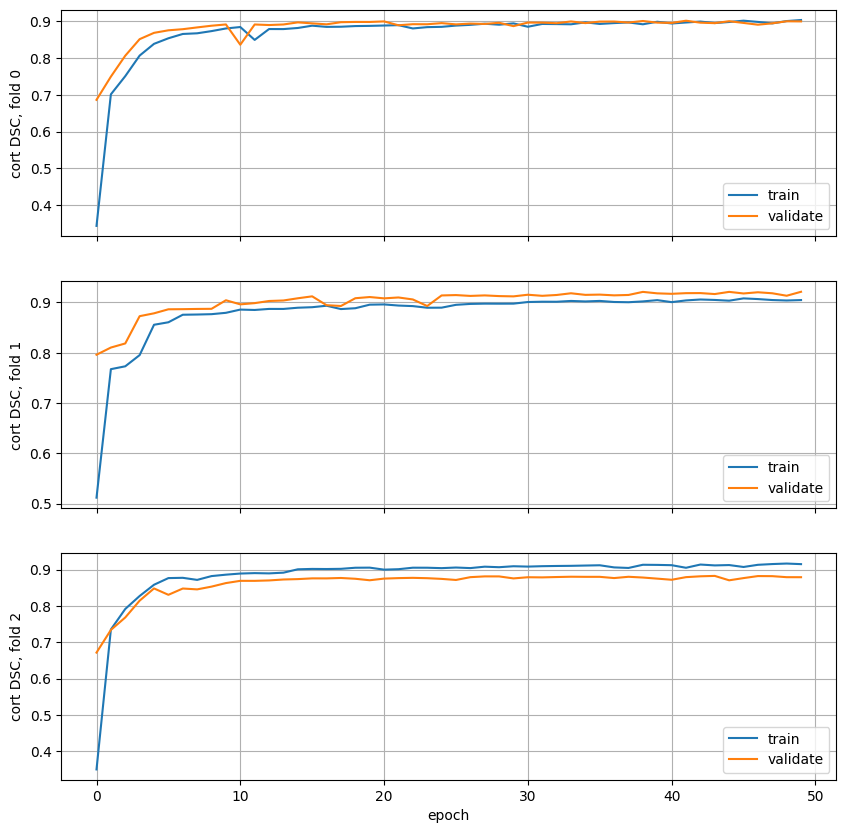

In [34]:
dfs_cv = []
for f in trange(num_folds):
    dfs_cv.append(pd.read_csv(f"logs/tutorial_cv/fold_{f}/metrics.csv"))

fig, axs = plt.subplots(len(dfs_cv), 1, sharex=True, figsize=(10,10))

for f, (ax, df) in enumerate(zip(axs,dfs_cv)):
    
    sns.lineplot(ax=ax, data=df, x="epoch", y="train_dsc_0_epoch", label="train")
    sns.lineplot(ax=ax, data=df, x="epoch", y="val_dsc_0_epoch", label="validate")
    
    ax.set_ylabel(f"cort DSC, fold {f}")
    
    ax.grid()

plt.show()

In [35]:
cort_dsc_avg = 0

for f, df in enumerate(dfs_cv):
    cort_dsc = df["val_dsc_0_epoch"].dropna().iloc[-1]
    cort_dsc_avg += cort_dsc
    print(f"Fold {f}, Cort DSC: {cort_dsc:0.3f}")

cort_dsc_avg = cort_dsc_avg / num_folds

print(f"Cross-validation average Cort DSC: {cort_dsc_avg:0.3f}")

Fold 0, Cort DSC: 0.900
Fold 1, Cort DSC: 0.921
Fold 2, Cort DSC: 0.879
Cross-validation average Cort DSC: 0.900


> **_NOTE:_** There are those who argue that k-fold CV is more legitimate than using a set-aside test set. Experiments that result in poor test-set performance do not get published - actually most of the time when someone gets bad test-set performance they probably do not just give up, or collect more data, they probably just switch to using k-fold CV anyways. This reporting bias results in published test set performances being artificially inflated. It's important to think all the way through an experimental plan before you start doing stuff. If you're going to use a set-aside test set, ask yourself what you would do if you got bad test set performance in the end? If you would not give up or collect more data, then you should seriously consider k-fold CV instead.